<center> <h1> Information Retrieval Assignment 1 </h1> </center>
<center> <h3> MSc. Artificial Intelligence </h3> </center>
<center> <h3> Mircea Mironenco </h2> </center>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from itertools import product
from __future__ import division
import seaborn as sns

In [2]:
# Some print helpers
def print_list(element_list):
    print '\n'.join([str(element) for element in element_list])

def print_clicked_list(clicked_list, clicks):
    for index, document in enumerate(clicked_list):
        clicked = clicks[index] == 1
        print '{0} {1}'.format(document,'was clicked' if clicked else ' ')

### Step 1
In the first step you will generate pairs of rankings of relevance, for the production P and experimental E, respectively, for a hypothetical query q. Assume a 3-graded relevance, i.e. {N, R, HR}. Construct all possible P and E ranking pairs of length 5

In [3]:
def construct_rankings(relev_length, pair_length, pairs):
    """
    Constructs pairs of rankings for a set of exepriments.
    
    itertools.product(A,B) will return cartesian product of A,B
    i.e. product(A,B) = [(x,y) for x in A for y in B]
    
    Args:
    - relev_length: Number of grades possible for a document.
    - pair_length: Length of a list of documents that are graded.
    - pairs: Number of systems we are producing rankings for.
    """
    return product(product(range(relev_length), repeat=pair_length), repeat=pairs)

In [4]:
rankings = list(construct_rankings(3, 5, 2))
print 'Produced a total of {0} pairs. Some examples:'.format(len(rankings))
print rankings[1567:1577]

Produced a total of 59049 pairs. Some examples:
[((0, 0, 0, 2, 0), (1, 1, 0, 0, 1)), ((0, 0, 0, 2, 0), (1, 1, 0, 0, 2)), ((0, 0, 0, 2, 0), (1, 1, 0, 1, 0)), ((0, 0, 0, 2, 0), (1, 1, 0, 1, 1)), ((0, 0, 0, 2, 0), (1, 1, 0, 1, 2)), ((0, 0, 0, 2, 0), (1, 1, 0, 2, 0)), ((0, 0, 0, 2, 0), (1, 1, 0, 2, 1)), ((0, 0, 0, 2, 0), (1, 1, 0, 2, 2)), ((0, 0, 0, 2, 0), (1, 1, 1, 0, 0)), ((0, 0, 0, 2, 0), (1, 1, 1, 0, 1))]


### Step 2

Implement 1 binary and 2 multi-graded evaluation measures out of the 7 measures mentioned above. 

(Note 2: Some of the aforementioned measures require the total number of relevant and highly relevant documents in the entire collection – pay extra attention on how to find this)

##### Binary precision - Precision at rank K

**Note**: Becuase our data is graded on a scale, and this is a binary evaluation measure, we make the following assumption:

**All documents that have any degree of relevancy are categorized as RELEVANT. Remaining documents are categorized as NOT RELEVANT.**

Example: *R HR HR R N*. First 4 documents are all *RELEVANT* (irrespective of the relative degree of relevancy), the last one is *NOT RELEVANT*.

In [203]:
def precision_at_rank(results,rank=5):
    """
    Given a list of results (i.e. documents/URLs)
    from a query. Returns the precision at the specified
    rank.
    
    x = 0 - NOT RELEVANT
    x > 0 - RELEVANT
    
    Args:
    - result: A set of relevance marks corresponding to documents.
    """
    if rank > len(results):
        raise Exception('Rank cannot be larger than document list.')
    
    return len([results[i] for i in range(rank) if results[i] > 0]) / rank

In [204]:
# Example binary evaluation using precision at rank k.
result = [0,1,1,0,2] # Equivalent to {N R R N HR}
print 'Binary precision at rank 5 for results [N R R N HR] is {0}.'.format(precision_at_rank(result,5))

Binary precision at rank 5 for results [N R R N HR] is 0.6.


##### Multi-graded evaluation measures.

Algorithms implemented:
- Discounted cumulative gain @ rank K. (DCG@K)

$DCG_{k} = \sum_{r=1}^{k} \dfrac{2^{REL(r)} - 1}{log_{2}(1+r)}$

- Rank biased precision with persistance parameter = 0.8. (RBP)

$RBP_{k} = (1 - \theta) \cdot \sum_{r=1}^{k} REL(r) \cdot \theta^{r-1}$

- Expected reciprocal rank. (ERR)

$\sum_{r=1}^{n} \frac{R_{r}}{r} \cdot \prod_{i=1}^{r-1} (1 - R_{i})$

In [205]:
def DCG(results, rank=5):
    """
    Given a list of results from a query,
    returns the Discounted Cumulative Gains
    at rank k.
    
    Note: Croft et al. (2010) and Burges et al. (2005) 
    present the second DCG with a log of base. This one
    uses a log base of 2, as discussed in the lectures.
    
    Args:
    - result: A set of relevance marks corresponding to documents.
    """
    return sum([(2**results[i-1] - 1) / np.log2(i + 1) for i in range(1, rank + 1)])

In [206]:
def RBP(results, rank=5, persistance=0.8):
    """
    Given a list of results from a query,
    returns the Rank biased precision with
    the specified persistance.
    
    A. Moffat and J. Zobel. -
    Rank-biased precision for measurement 
    of retrieval effectiveness.
    
    Args:
    - result: A set of relevance marks corresponding to documents.
    """
    
    return (1. - persistance) * sum([results[i] * persistance**i for i in range(rank)])

In [207]:
def ERR(results):
    """
    Given a list of results from a query,
    returns the expected reciprocal rank.
    
    Chapelle et al. - Expected Reciprocal Rank 
    for Graded Relevance
    
    Args:
    - result: A set of relevance marks corresponding to documents.
    """
    
    # Relevance grades, with maximum grade 2
    maximum_grade = 2**2
    R = [(2**grade - 1) / maximum_grade for grade in results]
    
    # O(N) ERR algorithm
    ERR, p = 0, 1
    for r in range(len(results)):
        ERR += p * R[r] / (r+1)
        p *= (1 - R[r])
    
    return ERR

In [208]:
# Example DCG, RBP, ERR evaluation
print DCG([2,2,0,0,1], 5)
print RBP([2,2,0,0,1], 5)
print ERR([2,2,0,0,1])

5.27964206795
0.80192
0.846875


### Step 3

Calculate the $\Delta$measure. For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.

In [209]:
def delta_measure(measure_algorithm, rankings, biased=True):
    """
    Construct groups of pairings between different algorithms,
    depending on the value of the delta measure, using different
    offline measuring techniques.
    
    Args:
    - measure_algorithm: Offline measuring algorithm to be applied (e.g DCG).
    - rankigns: A set of relevance marks corresponding to documents.
    - biased: Boolean value indicating whether or not to return only groups
    for which the delta measure is greater than 0.
    """
    results = []
    for production, experiment in rankings:
        delta_measure = measure_algorithm(experiment) - measure_algorithm(production)
        if biased:
            if delta_measure > 0:
                results.append((production, experiment, delta_measure))
        else:
            results.append((production, experiment, delta_measure))
    
    return results

In [210]:
rankings = list(construct_rankings(3, 5, 2))
dcg_biased_results, rbp_biased_results, err_biased_results = delta_measure(DCG, rankings), delta_measure(RBP, rankings), delta_measure(ERR, rankings)

In [211]:
print 'According to DCG are {0} instances where experimental > production.'.format(len(dcg_biased_results))
print 'According to RBP are {0} instances where experimental > production.'.format(len(rbp_biased_results))
print 'According to ERR are {0} instances where experimental > production.'.format(len(err_biased_results))

According to DCG are 29376 instances where experimental > production.
According to RBP are 29403 instances where experimental > production.
According to ERR are 29369 instances where experimental > production.


### Step 4

Implement interleaving. Implement 2 interleaving algorithms: 
- (1) Team-Draft Interleaving OR Balanced Interleaving, 
- (2), Probabilistic Interleaving. 

The interleaving algorithms should 

- (a) given two rankings of relevance interleave them into a single ranking, and 
- (b) given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

(Note 4: Make your implementation as generic as possible such that it could work outside this assignment.)

(Note 5: Note here that as opposed to a normal interleaving experiment where rankings consists of urls or docids, in our case the rankings consist of relevance labels. Hence in this case (a) you will assume that E and P return different documents, (b) the interleaved ranking will also be a ranking of labels.)

In [213]:
class Document(object):
    """
    Document class used to describe a document return
    by a search algorithm from a query.
    """
    def __init__(self, document_id, team, relevance=1):
        self.document_id = document_id
        self.team = team
        self.relevance = relevance
        
    def __repr__(self):
        return str(self.document_id) + ' from team ' + self.team
    
    def __eq__(self, other):
        # Documents are made unique by their id (position in array) and team name.
        return (self.document_id == other.document_id) and (self.team == other.team)
    
class InterleavedRanking(object):
    """
    Ranking of documents, obtained by using either the
    TeamDraft or Probabilistic interleaving algorithm.
    """
    def __init__(self, ranking, lists, algo_names):
        self.ranking = ranking
        self.lists = lists
        self.algo_names = algo_names

In [214]:
class TeamDraft(object):
    """
    Team draft interleaving algorithm class that
    can be used to sample, create an interleaved list,
    as well as evaluate clicks on.
    """
    
    def interleave(self, lists, algo_names):
        """
        Interleaves the two ranked lists and returns
        a ranking of all the documents. Assumes rankings 
        have 5 unique documents, and no document is 
        in another ranking.
        """
        if len(lists) < 2:
            raise Exception('Cannot interleave less than 2 lists.')
            
        i, j = 0, 0
        interleaved_docs = []
        rankingsA, rankingsB = lists[0], lists[1]
        
        # While we still have documents left in either rankings
        while (i < len(rankingsA) or j < len(rankingsB)):
            if i < len(rankingsA) and j < len(rankingsB):
                # There are still rankings in both lists.
                # Create document objects to be stored in list
                document_a = Document(document_id=i, team=algo_names[0], relevance=rankingsA[i])
                document_b = Document(document_id=j, team=algo_names[1], relevance=rankingsB[j])
                
                # Flip a coin to determine which goes first
                # Add documents to interleaved list
                coin_flip = np.random.randint(low=0, high=2)
                if coin_flip == 0: # First extract from rankingA
                    interleaved_docs.extend([document_a, document_b])
                else:
                    interleaved_docs.extend([document_b, document_a])
                i += 1
                j += 1
            elif i < len(rankingsA): # There are only documents left in ranking A
                while i < len(rankingsA):
                    document_a = Document(document_id=i, team=algo_names[0], relevance=rankingsA[i])
                    interleaved_docs.append(document_a)
                    i += 1
            else:
                while j < len(rankingsB): # There are only documents left in ranking A
                    document_b = Document(document_id=j, team=algo_names[1], relevance=rankingsB[j])
                    interleaved_docs.append(document_b)
                    j += 1
        
        # Create and return an InterleavedRanking object.
        interleaved_ranking = InterleavedRanking(ranking=interleaved_docs, 
                                                 lists=lists, 
                                                 algo_names=algo_names)
        return interleaved_ranking
    
    def _deterministic_scores(self, interleaved_ranking, clicks):
        """
        Given an interleaved set of documents, and a set of clicks
        determine the score associated with each algorithm that generated
        the documents.
        
        Args:
        - interleaved_ranking: Set of documents interleaved using TeamDraft
        - clicks: Array of 0/1 values indicating clicks at each index (rank).
        """
        # Get interleaved list and algorithm names.
        L = interleaved_ranking.ranking
        algo_names = interleaved_ranking.algo_names
        
        scores = [0,0]
        for i in range(len(clicks)):
            # Did click document at rank i
            clicked = clicks[i] == 1
            
            # If we did click the document at rank i, determine
            # which ranking algorithm produced that document
            # and increment it's points
            if clicked and (L[i].team == algo_names[0]):
                scores[0] += 1
            elif clicked and (L[i].team == algo_names[1]):
                scores[1] += 1
                
        return scores
    
    def evaluate(self, interleaved_ranking, clicks):
        """
        Returns the winning ranking algorithm. 
        """
        scores = self._deterministic_scores(interleaved_ranking, clicks)
#         print scores
        # Algorithms used to generate the individual rankings.
        # Determine winner using deterministically generated scores.
        algo_names = interleaved_ranking.algo_names
        
        # Return interleaved list and winner
        if scores[0] > scores[1]:
            return algo_names[0]
        elif scores[0] < scores[1]:
            return algo_names[1]
        else:
            return 'TIE'

In [215]:
class Softmax(object):
    
    def __init__(self, ranking, team, tau=3):
        """
        Softmax function used in a probabilistic
        interleaving algorithm. Assumes rankings have 5
        unique documents, and no document is in another ranking.
        
        Args:
        - tau: "Controls how quickly selection probabilities
        decay as as rank increases". Default is 3, as suggested
        in the paper.
        - ranking: A list of documents consisting a ranking by 
        a search algorithm.
        - team: Unique identifier for the ranking, which makes it easier
        to associate the document with the particular ranking.
        """
        
        self.tau = tau
        self.ranking = ranking
        self.documents = []
        # Create numerator/denominator for original ranking size.
        # Store documents from ranking.
        numerators = np.ndarray(len(ranking))
        for r in range(len(ranking)):
            # Create and store numerator for this rank
            rank_numerator = 1.0 / ((r+1)**tau)
            numerators[r] = rank_numerator
            
            # Store document
            self.documents.append(Document(document_id=r, team=team, relevance=ranking[r]))
            
        denominator = np.sum(numerators)
        # Store probabilities for each document
        self.probs = numerators / denominator
        
    def remove_document(self, document):
        """
        Removes a document from the set of documents
        managed by this softmax function.  Renormalizes
        the probabilities, and returns the probability
        of sampling the removed document from removal.
        """
        index = -1
        for i, curr_doc in enumerate(self.documents):
            if curr_doc == document:
                index = i
                break
        
        if index == -1:
            return 0
            
        # Probability of sampling document before deletion
        prob_document = self.probs[index]
        
        # Remove document
        self.documents.pop(index)
        
        # Renomralize probabilities
        self.probs = np.delete(self.probs, index)
        self.probs = self.probs / sum(self.probs)
        
        return prob_document
        
    def sample(self):
        """
        Used to sample a document from the softmax distribution.
        Picks and returns a document, renormalizes probabilities.
        """
        # We have no documents left
        if len(self.documents) < 1:
            return None
            
        # We have only 1 document left
        if len(self.documents) == 1:
            self.probs = np.delete(self.probs, 0) # Empty.
            pick = self.documents.pop()
            return pick
        
        # Otherwise sample from the distribution
        cumulative_probs = np.cumsum(self.probs)
        pick = -1
        rand = np.random.rand()
        for pos, cp in enumerate(cumulative_probs):
            if rand < cp:
                pick = self.documents.pop(pos) # Remove document from list.
                break
        
        # Ugly debugging check.
        if not isinstance(pick, Document) and pick == -1:
            print 'cumprobs'
            print 'rand'
            raise Exception('Could not select document')
        
        # Renormalization
        self.probs = np.delete(self.probs, pos)
        self.probs = self.probs / sum(self.probs)
        
        return pick
        

In [216]:
class Probabilistic(object):
    
    def __init__(self):
        self.softmaxs = {}
        
    def interleave(self, lists, algo_names, list_length=10):
        """
        Returns interleaved document list using 
        a probabilistic interleaving method.
        
        Args:
        - lists: A list of rankings to be interleaved,
        e.g. [rankingA, rankingB], where each ranking is 
        a list of documents.
        - algo_names: A list of names to be assigned to 
        each corresponding ranking. e.g. ['A','B'].
        """
        if len(lists) < 2:
            raise Exception('Cannot interleave less than 2 lists.')
            
        if list_length > sum([len(ranking) for ranking in lists]):
            raise Exception('Not enough documents available for requested length')
            
        # Create Softmax functions.
        for i, ranking in enumerate(lists):
            self.softmaxs[i] = Softmax(ranking, algo_names[i])
        
        # Create indexes of rankings.
        list_indexes = list(range(len(lists)))
        interleaved_docs = []
        
        # Start interleaving
        while len(interleaved_docs) < list_length:
            # Stochastically select a softmax to draw documents from.
            np.random.shuffle(list_indexes)
            selected_softmax = np.random.choice(list_indexes)
            
            # Sample and delete document from ranking.
            document = self.softmaxs[selected_softmax].sample()
            
            # No more documents in ranking list.
            if not document:
                # Remove list for future sampling to be
                # done from the other one.
                # Note: :remove: will eliminate the index of the
                # softmax list that is empty.
                list_indexes.remove(selected_softmax)
            else:
                # Add sampled document to interleaved list.
                interleaved_docs.append(document)
        
        # Create and return an InterleavedRanking object.
        interleaved_ranking = InterleavedRanking(ranking=interleaved_docs, 
                                                 lists=lists, 
                                                 algo_names=algo_names)
        
        return interleaved_ranking
    
    def _probabilistic_scores(self, interleaved_ranking, clicks):
        """
        Compute scores for each ranking.
        Implements marginalization comparison
        from the Probabilistic Interleaving paper.
        """
        # Interleaved list of documents.
        # Unpack elements, as each is used differently.
        L = interleaved_ranking.ranking
        lists = interleaved_ranking.lists
        algo_names = interleaved_ranking.algo_names 
        
        # Get set of documents that were clicked on.
        C = set()
        for i in range(len(clicks)):
            # If document at rank i is clicked
            # add it to the set of documents that were clicked on.
            if clicks[i] == 1:
                C.add(L[i])
    
        # Probability scores for each ranking.
        probability_scores = {0:0.0, 1:0.0}
        
        # All possible assignments.
        # used to marginalize and obtain outcomes.
        # example: [0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
        assignments = [list(arr[0]) for arr in construct_rankings(2,10,1)]
        
        for assignment in assignments:
            # initialize click probabilities
            c = [0,0]
            
            # Softmaxs for assignments
            R = [Softmax(lists[i], algo_names[i]) for i in range(len(lists))]
            
            prob = 1.0
            
            for assignment_index, document in zip(assignment, L):
                alternative_index = (assignment_index + 1) % 2
                
                if document in C:
                    c[assignment_index] += 1
                    
                    # Remove document and store
                    # probability of sampling before deletion
                    prob *= R[assignment_index].remove_document(document)
                    
                    # In case document are duplicated in lists
                    # Note: With the current implementation, this should
                    # never happen. As mentioned in the requirements, all
                    # documents should be unique. Implemented as a convenience.
                    try:
                        R[alternative_index].remove_document(document)
                    except:
                        pass
                    
                    # Assign probability score to whicever ranking
                    # produced the document.
                    if c[0] < c[1]:
                        probability_scores[1] += prob
                    elif c[0] > c[1]:
                        probability_scores[0] += prob
        
        # Return interleaved list and scores.
        return probability_scores
        
    def evaluate(self, interleaved_ranking, clicks):
        """
        Given a list of documents interleaved using the
        Probabilistic Interleaving algorithm and a set of clicks,
        determine the 'winning' algorithm.
        """
        # Get scores for each ranking.
        scores = self._probabilistic_scores(interleaved_ranking, clicks)

        # Team names to be outputted as result / winning algo.
        algo_names = interleaved_ranking.algo_names
        
        # Return interleaved list and winner
        if scores[0] > scores[1]:
            return algo_names[0]
        elif scores[1] > scores[0]:
            return algo_names[1]
        else:
            return 'TIE'

In [217]:
# Testing interleaving for both Team Draft
# and Probabilistic Interleaving algorithms.
probinter = Probabilistic()
teamdrft = TeamDraft()

# Rankings to be interleaved
rankingA = [1,2,2,1,2]
rankingB = [1,0,2,2,1]

# Interleaved lists from each algorithm
ranking_tdraft = teamdrft.interleave(lists=[rankingA, rankingB], algo_names=['A','B'])
ranking_probs = probinter.interleave(lists=[rankingA, rankingB], algo_names=['A','B'])

In [218]:
print 'Selected the following documents using Team Draft Interleaving:'
print_list(ranking_tdraft.ranking)
    
print '\nSelected the following documents using Probabilistic Interleaving'
print_list(ranking_probs.ranking)

Selected the following documents using Team Draft Interleaving:
0 from team B
0 from team A
1 from team A
1 from team B
2 from team B
2 from team A
3 from team B
3 from team A
4 from team B
4 from team A

Selected the following documents using Probabilistic Interleaving
0 from team B
1 from team A
0 from team A
1 from team B
2 from team B
4 from team B
2 from team A
3 from team B
3 from team A
4 from team A


In [219]:
# Test evaluations using clicks on Team Draft Algorithm
clicks = [1, 0, 1, 0, 1, 0, 0, 0, 0, 0] # Clicked on first, third, and fifth document.
rankingA = [1,2,2,1,2]
rankingB = [1,0,2,2,1]
teamdrft = TeamDraft()

# Generate interleaved document
interleaved_ranking = teamdrft.interleave(lists=[rankingA, rankingB], algo_names=['A','B'])

# Interleave list, and obtain evaluation by applying clicks
winner = teamdrft.evaluate(interleaved_ranking, clicks)

print_clicked_list(interleaved_ranking.ranking, clicks)
print '\nWinning ranking algorithm is ', winner

0 from team B was clicked
0 from team A  
1 from team B was clicked
1 from team A  
2 from team B was clicked
2 from team A  
3 from team A  
3 from team B  
4 from team B  
4 from team A  

Winning ranking algorithm is  B


In [220]:
# Test evaluations using clicks on Probabilistic Interleaving Algorithm
clicks = [1, 0, 1, 0, 1, 1, 0, 0, 0, 0] # Clicked on first, third, fifth, sixth document.
rankingA = [1,2,2,1,2]
rankingB = [1,0,2,2,1]
probinter = Probabilistic()

# Generate interleaved document
interleaved_ranking = probinter.interleave(lists=[rankingA, rankingB], algo_names=['A','B'])

# Interleave list, and obtain evaluation by applying clicks
winner = probinter.evaluate(interleaved_ranking, clicks)

print_clicked_list(interleaved_ranking.ranking, clicks)
print '\nWinning ranking algorithm is ', winner

0 from team A was clicked
1 from team A  
2 from team A was clicked
4 from team A  
3 from team A was clicked
0 from team B was clicked
2 from team B  
1 from team B  
3 from team B  
4 from team B  

Winning ranking algorithm is  A


# Step 5

Having interleaved all the ranking pairs an online experiment could be ran. However, given that we do not have any users (and the entire homework is a big simulation) we will simulate user clicks.

We have considered a number of click models including:
- Random Click Model (RCM)
- Position-Based Model (PBM)
- Simple Dependent Click Model (SDCM)
- Simple Dynamic Bayesian Network (SDBN)

Consider two different click models, (a) the Random Click Model (RCM), and (b) one out of the remaining 3 aforementioned models. The parameters of some of these models can be estimated using the Maximum Likelihood Estimation (MLE) method, while others require using the Expectation-Maximization (EM) method. Implement the two models so that 
- (a) there is a method that learns the parameters of the model given a set of training data. (**train_model**)
- (b) there is a method that predicts the click probability given a ranked list of relevance labels. (**predict_clicks**)
- (c) there is a method that decides - stochastically - whether a document is clicked based on these probabilities. (**is_clicked**)

Having implemented the two click models, estimate the model parameters using the Yandex Click Log (YandexRelPredChallenge.txt).

(Note 6: Do not learn the attractiveness parameter $𝑎_{uq}$.)

**Note on solution**: The chosen algorithms are **Random Click Model** and **Simple Dependent Click Model**

Before implementing the algorithms, I first preprocess the data. To do this I initally explore how the data is structured. The following are some experiments, in which I show the existence of some corner cases. The following are **assumptions** about the data that I will prove by exploring the dataset:

- A user session is composed of multiple queries, some of them having the same id, while other being different. There are cases where clicks happen on a document that is not in the immediatly previous query (from a time perspective). This can only mean that **the user is opening multiple tabs and doing searches in the same session**. I will rebuild the dataset so that user sessions are transformed in to query-sessions, which are used in click models literature. 


In [221]:
# Load data in pandas to be explored.
pdata = pd.read_csv('YandexRelPredChallenge.txt', sep='\t', header=None)
pdata.columns = ['session_id', 'time_passed', 'action_type', 'query_click_id', 'region_id',
                'docid_1', 'docid_2', 'docid_3', 'docid_4', 'docid_5',
                'docid_6', 'docid_7', 'docid_8', 'docid_9', 'docid_10']

Furthermore there are multiple sessions where:
- There are multiple queries with the same id and **exactly the same 10 documents.**. This corresponds to the user simply hitting enter again on a query.
- There are multiple queries with the same id, but **10 different documents**. This can be interpreted as the user going to the next page of search results, and will be treated accordingly (where in a cascade model, the documents on the second page start from rank 11, etc.)
- There are multiple queries with the same id, but **some documents are the same, while some are different**. This is not pagination, this is indicative of using a search engine where the algorithm is being updated in real time. These are a corner case and number around ~196 user sessions. 

In [224]:
# Example of user session where an identical query is repeated (same id, same 10 documents)
# See query with QUERY_ID = 9282
pdata[pdata['session_id'] == 9441]

,session_id,time_passed,action_type,query_click_id,region_id,docid_1,docid_2,docid_3,docid_4,docid_5,docid_6,docid_7,docid_8,docid_9,docid_10
70501,9441,0,Q,9282,1.0,78798.0,78799.0,78803.0,78800.0,78802.0,78804.0,78806.0,78801.0,78805.0,78807.0
70502,9441,34,C,78798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70503,9441,146,C,78798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70504,9441,832,Q,9282,1.0,78798.0,78799.0,78803.0,78800.0,78802.0,78804.0,78806.0,78801.0,78805.0,78807.0
70505,9441,850,C,78798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70506,9441,1639,Q,9282,1.0,78798.0,78799.0,78803.0,78800.0,78802.0,78804.0,78806.0,78801.0,78805.0,78807.0
70507,9441,1645,C,78798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70508,9441,1839,Q,146,1.0,1307.0,1369.0,1338.0,1339.0,1347.0,1359.0,1336.0,1321.0,1353.0,1308.0
70509,9441,1844,C,1307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70510,9441,1879,C,1307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
# Example of user session where an identical query is repeated 
# but 10 different documents are presented. (next page of search)
# See query with QUERY_ID = 6091
pdata[pdata['session_id'] == 8667]

,session_id,time_passed,action_type,query_click_id,region_id,docid_1,docid_2,docid_3,docid_4,docid_5,docid_6,docid_7,docid_8,docid_9,docid_10
64839,8667,0,Q,6091,1.0,52386.0,52392.0,52375.0,52377.0,52378.0,52391.0,52389.0,52371.0,7537.0,52368.0
64840,8667,20,C,52392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64841,8667,65,C,52386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64842,8667,89,Q,6091,1.0,52392.0,52389.0,52371.0,7537.0,73817.0,73830.0,73822.0,73826.0,73832.0,73827.0
64843,8667,114,C,52371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
# Example of user session where an identical query is repeated 
# but only the first ~7-8 documents are identical (with a 7 second time difference)
# while the other are different.
# See query with QUERY_ID = 4626
pdata[pdata['session_id'] == 5239]

,session_id,time_passed,action_type,query_click_id,region_id,docid_1,docid_2,docid_3,docid_4,docid_5,docid_6,docid_7,docid_8,docid_9,docid_10
40936,5239,0,Q,4626,0.0,40144.0,40152.0,40146.0,40158.0,40155.0,40151.0,40156.0,40157.0,40143.0,40148.0
40937,5239,7,Q,4626,0.0,40144.0,40152.0,40156.0,40369.0,40148.0,40146.0,40365.0,40357.0,40350.0,40368.0
40938,5239,19,Q,4712,0.0,40881.0,40893.0,40892.0,40899.0,40900.0,40906.0,40898.0,40888.0,40885.0,40902.0
40939,5239,42,C,40893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40940,5239,48,C,40906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data preprocessing - Design decisions

The following points explain the preprocessing of the data. We make the following modifications to the data:

- Queries within a sessions are transformed into query-session pairs, where the clicks present in the sessions are associated with the last query (from a time perspective) where the document is present.
- If queries are identical (same id and same documents) they are merged, however the position of a query is moved to the front (i.e. to the position of the second occurance of the same query).
- If queries are identical but have 10 completely different documents, they are merged into one query where the last 10 documenst are added to the documents of the initial query (i.e. 20 documents, 2 pages, pagination.), and the query is moved to the last position as the most recently seen one.
- Queries with the same id but only partially different documents are considered different queries.

In [227]:
class Query(object):
    def __init__(self, session_id, time_passed, query_id, region_id, documents):
        self.query_id = query_id
        self.session_id = session_id
        self.time_passed = time_passed
        self.region_id = region_id
        self.documents = documents
        self.clicks = []
        
    def has_click(self, click_document_id):
        """
        Determines if the clicked document is in this query
        and returns it's rank.
        """
        for rank, doc in enumerate(self.documents):
            if doc == click_document_id:
                return rank
        
        return -1
    
    def add_documents(self, documents):
        self.documents.extend(documents)
        
    def has_document(self, document_id):
        for doc in self.documents:
            if document_id == doc:
                return True
        
        return False
        
    def identical_queries(self, query_row):
        """
        Compares a query object with a query row
        from the Yandex log file.
        Returns True if they share the same id and all documents are identical.
        """
        if self.query_id == query_row[3]:
            for i in range(10):
                if self.documents[i] != query_row[5+i]:
                    return False
            return True
        return False
    
    def distinct_queries(self, query_row):
        """
        Compares a query object with a query row
        from the Yandex log file.
        Return True if they share the same id, but all 10 documents are different
        (i.e. one is the next page of the other)
        """
        if self.query_id == query_row[3]:
            for i in range(10):
                if self.documents[i] == query_row[5+i]:
                    return False
            return True
        return False

class Click(object):
    def __init__(self, session_id, time_passed, document_id, query_id, rank):
        self.session_id = session_id
        self.document_id = document_id
        self.time_passed = time_passed
        self.query_id = query_id
        self.rank = rank

In [230]:
def getYandexData():
    """
    Used to retrieve stripped yandex rows from the text file.
    """
    data = []
    with open('YandexRelPredChallenge.txt') as f:
        for row in f:
            row_data = row.split('\t')
            row_data = [col.strip() for col in row_data]
            data.append(row_data)
    return data

In [231]:
# First run last cell, for data preprocessing algorithm
yandex_queries = preprocess_yandex_data()
print 'After data processing there are {0} query-session pairs.'.format(len(yandex_queries))

After data processing there are 38686 query-session pairs.


### Click model implementations

Requirements:
- (a) there is a method that learns the parameters of the model given a set of training data. (**train_model**)
- (b) there is a method that predicts the click probability given a ranked list of relevance labels. (**predict_click_prob**)
- (c) there is a method that decides - stochastically - whether a document is clicked based on these probabilities. (**is_clicked** in RCM, merged with second method in SDCM)

### Random Click Model

In [232]:
class RCM(object):
    # Random Click Model
    def __init__(self, prob=0.5):
        # Set default probability
        # this variable will be estimated using MLE.
        self.click_prob = prob 
        
    def train_model(self, queries):
        """
        Given a set of query-session pairs 
        (containing both clicks and queries),
        learn the probability of clicking on a document,
        estimated as:
        --> p = number of clicks / number of documents.
        """
        num_clicks = sum([len(query.clicks) for query in queries])
        num_docs = sum([len(query.documents) for query in queries])
        
        # MLE estimation
        self.click_prob = num_clicks / num_docs
    
    def predict_click_prob(self, documents):
        """
        The probability of a click is associated with the probability
        of each document.
        
        Args:
        - :documents: A list (ranking) of document objects.
        """
        # There is no 'prediction' here, as this is the 
        # random click model, the probability of a click is
        # the only parameter whe know
        # simply associated the probability of clicking each document
        return np.ones_like(documents) * self.click_prob
    
    def is_clicked(self, documents):
        # Get probabilities for each document
        # based on predict probability method.
        click_probs = self.predict_click_prob(documents)
        
        # Return 1 - Click/0 - No click depending on if the document is clicked
        return [1 if (np.random.uniform(0,1) <= click_prob) else 0 for click_prob in click_probs]

In [233]:
# Instantiate and train the model
random_click_model = RCM()
random_click_model.train_model(yandex_queries)

# Probability of clicking on a document
print 'Random Click Model probability inferred by training on yandex logs is ', random_click_model.click_prob

# Test the random click model on an interleaved list.
rankingA, rankingB = [1,2,2,1,2], [1,0,2,2,1]
teamdrft = TeamDraft()

# Generate interleaved document
interleaved_ranking = teamdrft.interleave(lists=[rankingA, rankingB], algo_names=['A','B'])

# Predict if documents are clicked, given a set of documents with relevance labels.
print 'RCM predicts the following clicks: ',random_click_model.is_clicked(interleaved_ranking.ranking)

Random Click Model probability inferred by training on yandex logs is  0.147983381932
RCM predicts the following clicks:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


### Simple dependent click model

**Note**: I have merged the last 2 methods in this class, as the probability of clicking on a document is also dependent on the previous clicks.

In [237]:
class SDCM(object):
    # Simple dependent click model
    def __init__(self, num_documents):
        # num_documents = maximum number of documents for a query.
        self.num_documents = num_documents
        
        # Continuation parameter default value.
        self.lmbd = [0.5] * num_documents
    
    def train_model(self, queries):
        """
        Given a set of query-session pairs 
        (containing both clicks and queries),
        learn the continuation paramter = 1 - satisfaction.
        continuation = 1 - (number of times rank r is last clicked document) / # times rank r is clicked.
        """
        # Store last rank clicks for each rank
        last_rank_clicks = [0] * self.num_documents
        
        # Store clicks for each rank
        rank_clicks = [0] * self.num_documents
        
        for query in queries:
            # For each queries that has clicks
            if len(query.clicks) > 0:
                # Record last click
                last_click = query.clicks[-1]
                last_rank_clicks[last_click.rank] += 1
                
                # Record all clicks, including last rank click
                # as formula is last_clicks_at_r / total_clicks_at_r
                # including when it is the last click
                for i in range(len(query.clicks)):
                    click = query.clicks[i]
                    rank_clicks[click.rank] += 1
        
        # Compute continuation parameters
        for r in range(0, len(self.lmbd)):
            satisfaction = (last_rank_clicks[r] / rank_clicks[r])
            self.lmbd[r] = 1.0 - satisfaction
        
    def predict_and_click(self, documents):
        """
        Given a set of documents with relevance labels, returns the probability of clicking
        each one and the ones that were clicked, using the
        Simplified Dependent Click Model algorithm, which implements:
        
        (1) P(C_u = 1) = alpha_u * e_u (attractiveness time examination)
        (2) P(C_u = 1 | C_{<r_u}) = alpha_u * e_u where,
        (3) e_{r+1} = C_r * lambda_r + (1 - C_r) * ((1 - alpha_u) * e_r / 1 - alpha_u * e_r
        
        Args:
        - :documents: A list (ranking) of document objects.
        """
        # To compute attractiveness of each document
        # take the relevance of the document * 1.0 / max_relevance
        max_relevance = 2.1
        prev_examination = 1.0
        
        # Store and return the clicks and probabilities
        clicks = [0] * len(documents)
        probs = [0] * len(documents)
        
        for r in range(len(documents)):
            # Attractiveness is determine using the relevance label.
            # Maximum relevance is 2, so the attractiveness for each document
            # is calculated using relevance_u / max_relevance + 0.1
            # This is done based on the assumption that no documents is ever
            # perfectly relevant (i.e. 1.0 attractiveness).
            alpha = documents[r].relevance / max_relevance
            
            # Determine examination probability.
            # Examination for first document is 1
            examination = 1
            
            if r > 0:
                # We are not at the first document
                # Compute examination probability
                
                if clicks[r-1] == 1:
                    # If we have a click at the previous document
                    # the examination probability = continuation probability
                    examination = self.lmbd[r-1]
                else:
                    # Attractiveness of previous document
                    previous_alpha = documents[r-1].relevance / max_relevance
                    
                    # Current examination probability
                    examination = ((1 - previous_alpha) * prev_examination) / (1 - previous_alpha * prev_examination)
            
            prev_examination = examination
            
            # Compute probability and stochastically determine if document was clicked.
            click_probability = alpha * examination
            did_click = np.random.uniform(0,1) <= click_probability
            
            probs[r] = click_probability
            clicks[r] = 1 if did_click else 0
        
        return probs, clicks
    
    def is_clicked(self, documents):
        # Return only clicks
        _, clicks = self.predict_and_click(documents)
        return clicks

In [238]:
# Instantiate and train the model
sdcm_click_model = SDCM(20)
sdcm_click_model.train_model(yandex_queries)

# Continuation probabilities
print 'After training on Yandex logs, the SDCM probabilities of continuation for the first 10 ranks are: '
print_list(sdcm_click_model.lmbd[:10])

# Test the Simple dependent click model on an interleaved list.
rankingA, rankingB = [1,2,2,1,2], [1,0,2,2,1]
teamdrft = TeamDraft()

# Generate interleaved document
interleaved_ranking = teamdrft.interleave(lists=[rankingA, rankingB], algo_names=['A','B'])

print 'Testing SDCM click prediction on interleaved list.\n'

click_probs, did_click = sdcm_click_model.predict_and_click(interleaved_ranking.ranking)
print 'Click probabilities are ', click_probs
print 'Clicked documents are ', did_click

print '\nAnother prediction, only clicks: '
print sdcm_click_model.is_clicked(interleaved_ranking.ranking)

After training on Yandex logs, the SDCM probabilities of continuation for the first 10 ranks are: 
0.415054787994
0.584873760144
0.609322974473
0.619697606048
0.615822270387
0.599480688088
0.586334942443
0.543369474562
0.526833631485
0.282219309742
Testing SDCM click prediction on interleaved list.

Click probabilities are  [0.47619047619047616, 0.47619047619047616, 0.5570226287088325, 0.0, 0.5803075947360075, 0.06584273301311461, 0.0016781800824784271, 0.0017610487767206705, 8.400740669892987e-05, 2.000344393719544e-06]
Clicked documents are  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

Another prediction, only clicks: 
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Step 6 - Simulate interleaving experiment

Having implemented the click models, it is time to run the simulated experiment.

For each of interleaved ranking run N simulations for each one of the click models implemented and measure the proportion p of wins for E.

(Note 7: Some of the models above include an attractiveness parameter 𝑎uq. Use the relevance label to assign this parameter by setting 𝑎uq for a document u in the ranked list accordingly. (See Click Models for Web Search)

In [236]:
# For each measure we want to take the pairs for which E outperforms P (biased)
# and all the normal pairs.
# Construct all possible rankings using function from step 1.
rankings = list(construct_rankings(3, 5, 2))

# All groups of the form (production, experiment, delta_measure) for which 
# the Experimental algorithm beats the Production algorithm, according to
# the three previously implemented evaluation measures: DCG, RBP, ERR.
dcg_biased_pairs = np.array(delta_measure(DCG, rankings))
rbp_biased_pairs = np.array(delta_measure(RBP, rankings))
err_biased_pairs = np.array(delta_measure(ERR, rankings))

biased_measurements = [dcg_biased_pairs, rbp_biased_pairs, err_biased_pairs]

# Same groups but unbiased, contains all pairs from each measurement.
dcg_pairs = np.array(delta_measure(DCG, rankings, biased=False))
rbp_pairs = np.array(delta_measure(RBP, rankings, biased=False))
err_pairs = np.array(delta_measure(ERR, rankings, biased=False))

unbiased_measurements = [dcg_pairs, rbp_pairs, err_pairs]

# Train the click models beforehand, on the yandex logs.
yandex_queries = preprocess_yandex_data()

rcm = RCM()
rcm.train_model(yandex_queries)

sdcm = SDCM(20) # 20 documents - maximum of 2 pages for a query.
sdcm.train_model(yandex_queries)

# Initialize interleaving algorithms.
team_draft = TeamDraft()
prob_draft = Probabilistic()

In [35]:
# The logical steps that should be taken for the online case are: 
# 1. Take a pair of rankings with relevance for labels
# 2. Generate the interleaved list using one of the interleaving algorithms.
# 3. Give that interleaved list to the SDCM/ RCM model which is trained on yandex, 
# and determine the positions at which clicks happen.
# 4. Using the algorithm you used to implement the interleaving model, evaluate the
# 'winner' by using the interleaved list and the clicks.
# 5. Count all the winners, and compare the proportion of cases where E wins
# from the online model with offline model.


interleaving_algos = [team_draft, prob_draft]
click_algos = [rcm, sdcm]

def get_online_results(measurements, num_simulations=35, num_samples=100):
    """
    Performs an online exepriemnt, using both interleaving algorithms, both
    click models, and all offline measures.
    
    Args:
    - measurements: The offline measurements data to be experimented on.
    - num_simulations: Number of click simulations for each experiment.
    - num_samples: Number of pairs of samples to take from each offline dataset.
    """
    # Split results into the specific measurement, and interleaving algorithm
    # they come from, for in-depth analysis at step 7.
    online_results = {'DCG':{'team':{'RCM':[],'SDCM':[]},
                             'probabilistic':{'RCM':[], 'SDCM':[]}}, 
                        'RBP':{'team':{'RCM':[],'SDCM':[]},
                               'probabilistic':{'RCM':[],'SDCM':[]}}, 
                        'ERR':{'team':{'RCM':[],'SDCM':[]},
                               'probabilistic':{'RCM':[],'SDCM':[]}}}

    # For each type of measurement
    for measure_index, off_pairs_group in enumerate(measurements):
        # Sample (without replacement) a number of pairs from this group
        pairs_samples = off_pairs_group[np.random.choice(len(off_pairs_group), num_samples, replace=False)]

        # For each sample pair.
        for sample_num, sample in enumerate(pairs_samples):
            if sample_num % 25 == 0:
                print 'Analyzing sample {0} from measurement {1}'.format(sample_num, measure_index)

            # Algorithms to compare
            production_ranking = sample[0]
            experimental_ranking = sample[1]

            # For each interleaving algorithm
            for algo_index, interleaving_algo in enumerate(interleaving_algos):
                # Create interleaved list.
                interleaved_list = interleaving_algo.interleave([production_ranking, experimental_ranking], ['P', 'E'])

                for click_index, click_algorithm in enumerate(click_algos):
                    # Record number of wins for each algorithm
                    e_wins = 0
                    p_wins = 0

                    # Run 'num_simulations' experiments on the list.
                    for simulation_index in range(num_simulations):
                        # Simulate clicks
                        clicks = click_algorithm.is_clicked(interleaved_list.ranking)

                        # Determine winner
                        winner = interleaving_algo.evaluate(interleaved_list, clicks)
                        if winner == 'E':
                            e_wins += 1
                        elif winner == 'P':
                            p_wins += 1


                    # Set which interleaving algorithm and measurement produced result
                    algo_name = 'team' if algo_index == 0 else 'probabilistic'
                    measure_name = ''
                    if measure_index == 0:
                        measure_name = 'DCG'
                    else:
                        measure_name = 'RBP' if measure_index == 1 else 'ERR'

                    # Determine click algorithm used
                    click_name = 'RCM' if click_index == 0 else 'SDCM'
                                        
                    # Save result, save pair, delta_measurement and proportion.
                    proportion = e_wins / (e_wins + p_wins)
                    online_results[measure_name][algo_name][click_name].append((sample, proportion))
    return online_results

In [ ]:
# Run online simulation on biased data
biased_online_results = get_online_results(biased_measurements)

In [ ]:
# Save data
biased_file_name = 'biased_online_results.p'
with open(biased_file_name, 'wb') as fp:
    pickle.dump(biased_online_results, fp)

In [ ]:
# Run online simulation on normal data
general_online_results = get_online_results(unbiased_measurements)

In [ ]:
# Save data
general_file_name = 'general_online_results.p'
with open(general_file_name, 'wb') as fp:
    pickle.dump(general_online_results, fp)

### Step 7 - Results and Analysis 

In the following section I perform an analysis by studying: 
- **Biased data** - Random samples from the cases where for the offline measures (DCG,RBP,ERR) $\Delta measure > 0$ (E wins)
- **Normal data** - Random samples from the entire dataset.

In [36]:
with open('biased_online_results.p', 'rb') as fp:
    biased_online_results = pickle.load(fp)

In [37]:
with open('general_online_results.p', 'rb') as fp:
    general_online_results = pickle.load(fp)

In [38]:
# Study biased results first
# Separate results dependeing on measurement and  click/interleaving algorithm.
biased_DCG, biased_RBP, biased_ERR = biased_online_results['DCG'], biased_online_results['RBP'], biased_online_results['ERR']
unbiased_DCG, unbiased_RBP, unbiased_ERR = general_online_results['DCG'], general_online_results['RBP'], general_online_results['ERR']

def print_measurement_results(measurement, measurement_name, num_samples):
    print 'For {0} pairs sampled from the dataset, the results for {1} are: '.format(num_samples, measurement_name)
    for interleaving_algo in measurement:
        algo_name = 'Team Draft Interleaving' if interleaving_algo == 'team' else 'Probabilistic Interleaving'
        algo_results = measurement[interleaving_algo]

        for click_model in algo_results:
            click_name = 'Random Click Model' if click_model == 'RCM' else 'Simple Dependent Click Model'
            click_results = algo_results[click_model]

            # Compute absolute number of time proportion is greater than > 0.5
            # Also compute the average value of the proportion.
            e_greater = sum([int(click_results[i][1] > 0.5) for i in range(len(click_results))]) # Number of times p > 0.5
            
            # Compute average proportion values.
            avg_proportion = sum([click_results[i][1] for i in range(len(click_results))]) / len(click_results)
            
            print '------------------'
            print 'Using {0} and {1}. \nThe number of times the proportion(e_wins) > 0.5 is {2}/{3}'.format(algo_name, click_name, e_greater, len(click_results))
            print 'The average proportion of times E wins is {0}'.format(avg_proportion)
            print '------------------'
    print '\n'


In [39]:
# Considering only measurements from the offline experiment where E > P
print_measurement_results(biased_DCG, 'Biased Discounted Cumulative Gains', 100)
print_measurement_results(biased_RBP, 'Biased Rank-biased precision', 100)
print_measurement_results(biased_ERR, ' Expected Reciprocal Rank', 100)

For 100 pairs sampled from the dataset, the results for Biased Discounted Cumulative Gains are: 
------------------
Using Probabilistic Interleaving and Random Click Model. 
The number of times the proportion(e_wins) > 0.5 is 37/100
The average proportion of times E wins is 0.476888769934
------------------
------------------
Using Probabilistic Interleaving and Simple Dependent Click Model. 
The number of times the proportion(e_wins) > 0.5 is 60/100
The average proportion of times E wins is 0.621069666576
------------------
------------------
Using Team Draft Interleaving and Random Click Model. 
The number of times the proportion(e_wins) > 0.5 is 40/100
The average proportion of times E wins is 0.49096818663
------------------
------------------
Using Team Draft Interleaving and Simple Dependent Click Model. 
The number of times the proportion(e_wins) > 0.5 is 81/100
The average proportion of times E wins is 0.732384090706
------------------


For 100 pairs sampled from the dataset, 

In [40]:
# Considering measurements from the entire set of offline experiments (no bias)
print_measurement_results(unbiased_DCG, 'Discounted Cumulative Gains', 100)
print_measurement_results(unbiased_RBP, 'Rank-biased precision', 100)
print_measurement_results(unbiased_ERR, 'Rank-biased precision', 100)

For 100 pairs sampled from the dataset, the results for Discounted Cumulative Gains are: 
------------------
Using Probabilistic Interleaving and Random Click Model. 
The number of times the proportion(e_wins) > 0.5 is 36/100
The average proportion of times E wins is 0.481810708186
------------------
------------------
Using Probabilistic Interleaving and Simple Dependent Click Model. 
The number of times the proportion(e_wins) > 0.5 is 50/100
The average proportion of times E wins is 0.491142857143
------------------
------------------
Using Team Draft Interleaving and Random Click Model. 
The number of times the proportion(e_wins) > 0.5 is 53/100
The average proportion of times E wins is 0.513907486002
------------------
------------------
Using Team Draft Interleaving and Simple Dependent Click Model. 
The number of times the proportion(e_wins) > 0.5 is 49/100
The average proportion of times E wins is 0.469385185524
------------------


For 100 pairs sampled from the dataset, the re

In [171]:
rez = []
for dataset_index, dataset in enumerate([biased_online_results, general_online_results]):
    # Measurement of total results for datasets
    total_e_wins = 0 # Total number of times the proportion e_wins > 0.5
    total_pairs = 0
    for measurement in dataset:
        for interleaving_algo in dataset[measurement]:
            for click_model in dataset[measurement][interleaving_algo]:
                results = dataset[measurement][interleaving_algo][click_model]
                total_e_wins += sum([int(results[i][1] > 0.5) for i in range(len(results))])
                total_pairs += len(results)
               
    rez.append((total_e_wins, total_pairs))
    dataset_name = 'biased' if dataset_index == 0 else 'general'
    print 'For the {0} dataset, the average number of times the proportion p (e wins) > 0.5 is {1}'.format(dataset_name ,total_e_wins / total_pairs)

For the biased dataset, the average number of times the proportion p (e wins) > 0.5 is 0.584158415842
For the general dataset, the average number of times the proportion p (e wins) > 0.5 is 0.456270627063


### Binomial signifiance test

In [239]:
# Separate data
biased_success = rez[0][0]
biased_trials = rez[0][1]

general_success = rez[1][0]
general_trials = rez[1][1]

# Use statistical binomial test to see if probability of success is:
# H0: greater than 0.5
# H1: lesser than 0.5
print 'Biased dataset E proportion > 0.5 with confidence', scipy.stats.binom_test(x=biased_success, n=biased_trials, p=0.5, alternative='less') # One-sided binomial test
print 'General dataset E proportion > 0.5 with confidence', scipy.stats.binom_test(x=general_success, n=general_trials, p=0.5, alternative='less') # One-sided binomial test

Biased dataset E proportion > 0.5 with confidence 0.999999998207
General dataset E proportion > 0.5 with confidence 0.0012733798075


### Plots

In [116]:
# Now separate results in lists, and plot them. Use signed binomial test and seaborn for plotting
def res_lists(measurement, pandas=True):
    # Theoretically there are 4 lists for each measurement -> 12 lists  
    # Preprocess each list so that only delta_measure and proportion remains
    # from each element in the list, the values in the pairs are not relevant now
    RCM_team = np.array([[element[1], element[0][2]] for element in measurement['team']['RCM']])
    RCM_prob = np.array([[element[1], element[0][2]] for element in measurement['probabilistic']['RCM']])
    SDCM_team = np.array([[element[1], element[0][2]] for element in measurement['team']['SDCM']])
    SDCM_prob = np.array([[element[1], element[0][2]] for element in measurement['probabilistic']['SDCM']])
    
    if pandas:
        RCM_team = pd.DataFrame(RCM_team, columns=['x', 'y'])
        RCM_prob = pd.DataFrame(RCM_prob, columns=['x', 'y'])
        SDCM_team = pd.DataFrame(SDCM_team, columns=['x', 'y'])
        SDCM_prob = pd.DataFrame(SDCM_prob, columns=['x', 'y'])
    
    return RCM_team, RCM_prob, SDCM_team, SDCM_prob

In [117]:
# DCG
dcg_lists = res_lists(general_online_results['DCG'])
biased_dcg_lists = res_lists(biased_online_results['DCG'])
# RBP
rbp_lists = res_lists(general_online_results['RBP'])
biased_rbp_lists = res_lists(biased_online_results['RBP'])
# ERR
err_lists = res_lists(general_online_results['ERR'])
biased_err_lists = res_lists(biased_online_results['ERR'])

In [118]:
def plot_proportion_distribution(dataset, title):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12,6))
    
    # Set title, axis labels.
    fig.suptitle(title)
    x_axis = [['RCM-TeamDraft \nE success ratio', 'RCM-Probabilistic \nE success ratio','SDCM-TeamDraft \nE success ratio','SDCM-Probabilistic \nE success ratio'],
              ['RCM-TeamDraft \nE success ratio', 'RCM-Probabilistic \nE success ratio','SDCM-TeamDraft \nE success ratio','SDCM-Probabilistic \nE success ratio'],
             ['RCM-TeamDraft \nE success ratio', 'RCM-Probabilistic \nE success ratio','SDCM-TeamDraft \nE success ratio','SDCM-Probabilistic \nE success ratio']]
    y_axis = ['DCG','RBP','ERR']
    
    # Plot all distributions
    for r, dataset_lists in enumerate(dataset):
        for c, d_list in enumerate(dataset_lists):
            proportions = d_list.iloc[:,0].values
            ax = sns.distplot(proportions, ax=axs[r][c])
            if c == 0:
                ax.set(xlabel=x_axis[r][c],ylabel=y_axis[r])
            else:
                ax.set(xlabel=x_axis[r][c],ylabel='')

#### Analysis of proportion p's distribution for both biased and general dataset.

Plot the distribution of the value of p (the proportion of E wins). If the online and offline evaluation techinques have a correlation we should see a tendency for the biased dataset (where we have taken only those pairs for which E won) to have a distribution with a larger mean than the normal dataset.

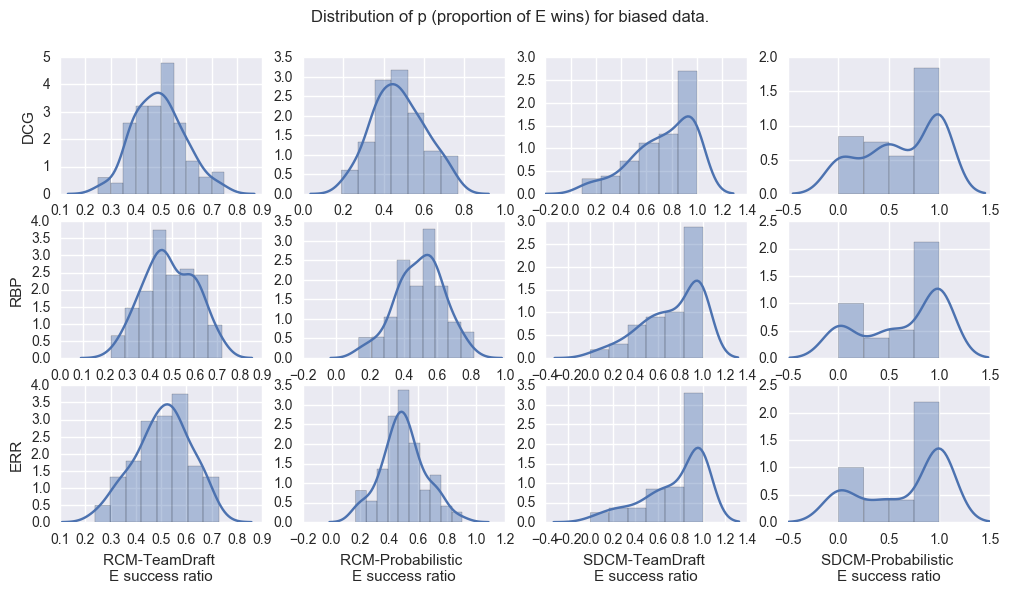

In [119]:
# Plot biased dataset proportion distribution
biased_dataset = [biased_dcg_lists, biased_rbp_lists, biased_err_lists]
plot_proportion_distribution(biased_dataset, 'Distribution of p (proportion of E wins) for biased data.')

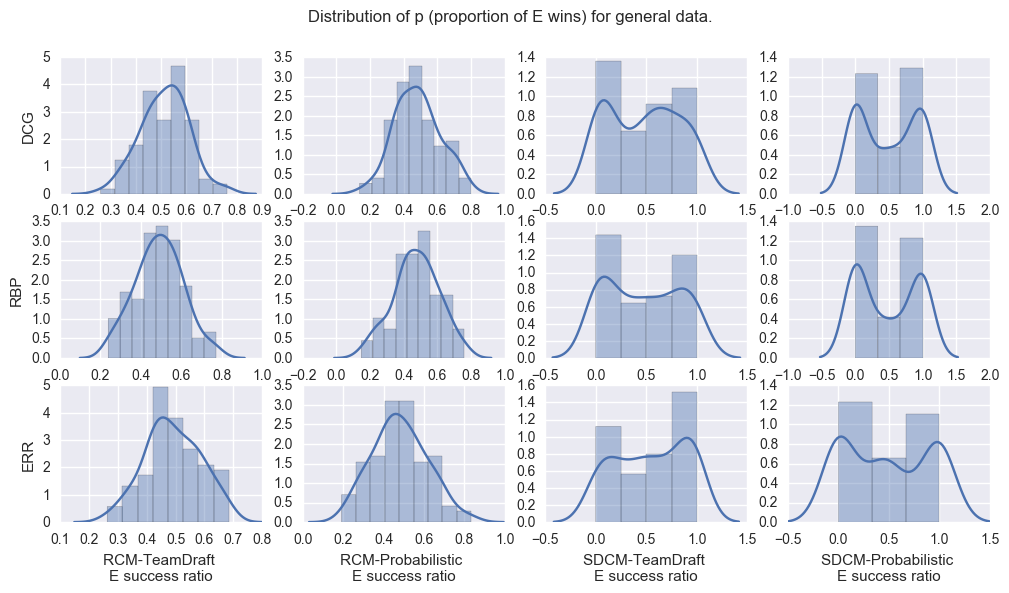

In [120]:
# Plot biased dataset proportion distribution
general_dataset = [dcg_lists, rbp_lists, err_lists]
plot_proportion_distribution(general_dataset, 'Distribution of p (proportion of E wins) for general data.')

In [121]:
def plot_bivariate_distributions(dataset, title):
    # Function to plot the distribution of data
    # for both proportion (x axis) and delta measure (y axis)
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12,6))
    fig.suptitle(title)
    x_axis = [['RCM-TeamDraft \nE success ratio', 'RCM-Probabilistic \nE success ratio','SDCM-TeamDraft \nE success ratio','SDCM-Probabilistic \nE success ratio'],
              ['RCM-TeamDraft \nE success ratio', 'RCM-Probabilistic \nE success ratio','SDCM-TeamDraft \nE success ratio','SDCM-Probabilistic \nE success ratio'],
             ['RCM-TeamDraft \nE success ratio', 'RCM-Probabilistic \nE success ratio','SDCM-TeamDraft \nE success ratio','SDCM-Probabilistic \nE success ratio']]
    y_axis = ['DCG \n$\Delta measure$','RBP \n$\Delta measure$','ERR \n$\Delta measure$']
    
    for r, dataset_lists in enumerate(dataset):
        for c, d_list in enumerate(dataset_lists):
            ax = sns.kdeplot(d_list.x, d_list.y, shade=True, cmap='Blues', ax=axs[r][c])
            ax.set_xlim(0,1)
            
            if c == 0:
                ax.set(xlabel=x_axis[r][c], ylabel=y_axis[r])
            else:
                ax.set(xlabel=x_axis[r][c], ylabel='')

#### Analysis of both $\Delta measure$ and p-proportion

Plot the bivariate distribution of the proportion and the delta measure, thus effectively comparing and obtaining an idea about the correlation of the 2 variables. 

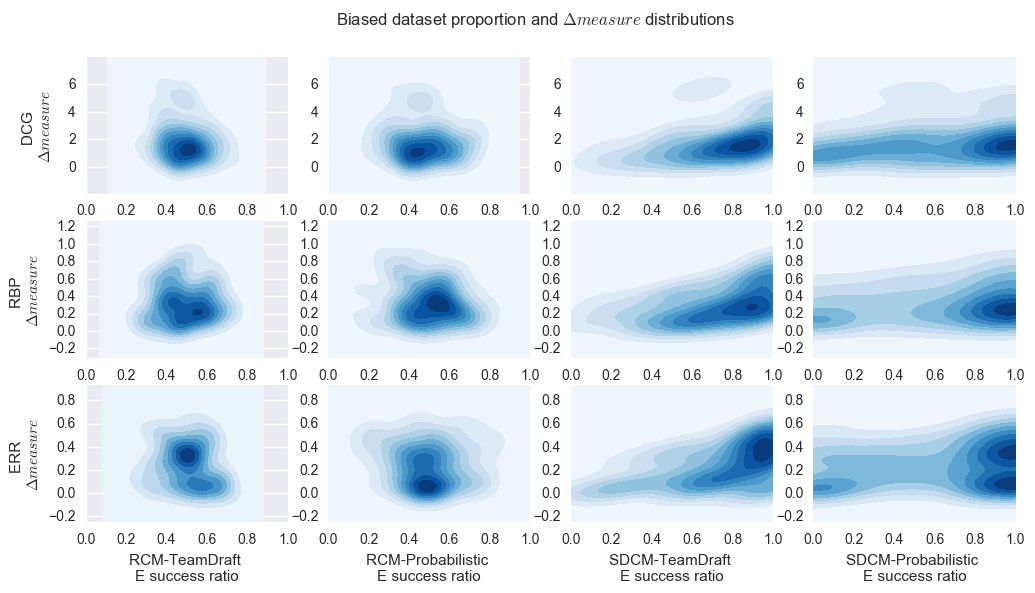

In [156]:
# Plot distributions for biased dataset
plot_bivariate_distributions(biased_dataset, 'Biased dataset proportion and $\Delta measure$ distributions')

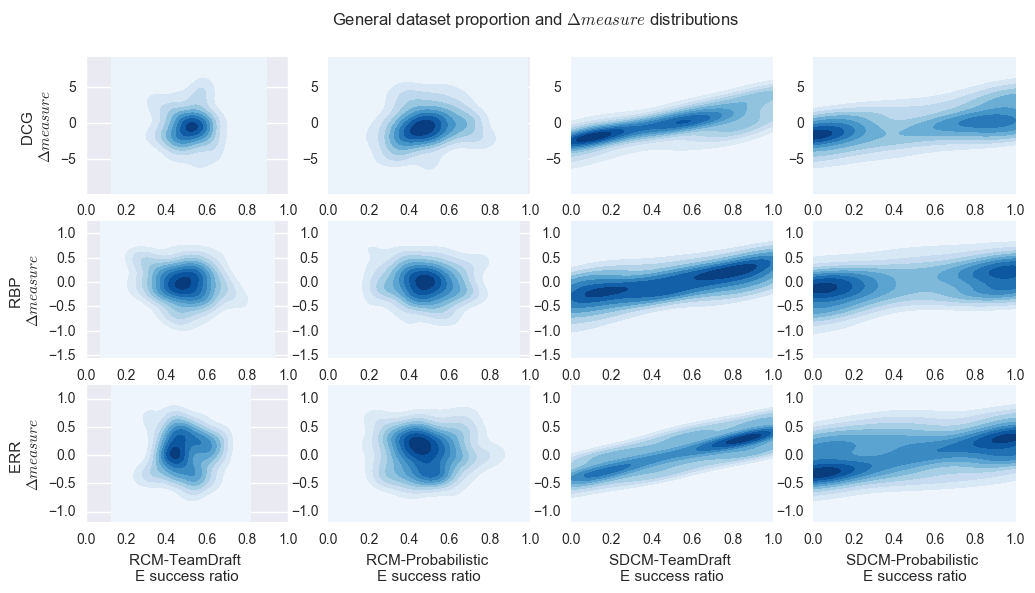

In [157]:
# Plot distributions for general dataset
plot_bivariate_distributions(general_dataset, 'General dataset proportion and $\Delta measure$ distributions')

In [ ]:
# Studying individual datasets will help us determine even more conclusive results
# DCG
# dcg_lists = res_lists(general_online_results['DCG'], pandas=False)
biased_dcg_lists = res_lists(biased_online_results['DCG'], pandas=False)
# RBP
# rbp_lists = res_lists(general_online_results['RBP'], pandas=False)
biased_rbp_lists = res_lists(biased_online_results['RBP'], pandas=False)
# ERR
# err_lists = res_lists(general_online_results['ERR'], pandas=False)
biased_err_lists = res_lists(biased_online_results['ERR'], pandas=False)


# We merge RCM and SDCM results, for each dataset, and study trends on the larger datasets.
# This analysis is performed only on the biased dataset, for brevity and to provide further
# insights into the coorrelation between the offline and online results.
DCG_biased_RCM = pd.DataFrame(np.vstack((biased_dcg_lists[0],biased_dcg_lists[1])), columns=['x','y'])
DCG_biased_SDCM = pd.DataFrame(np.vstack((biased_dcg_lists[2],biased_dcg_lists[3])), columns=['x','y'])

RBP_biased_RCM = pd.DataFrame(np.vstack((biased_rbp_lists[0],biased_rbp_lists[1])), columns=['x','y'])
RBP_biased_SDCM = pd.DataFrame(np.vstack((biased_rbp_lists[2],biased_rbp_lists[3])), columns=['x','y'])

ERR_biased_RCM = pd.DataFrame(np.vstack((biased_err_lists[0],biased_err_lists[1])), columns=['x','y'])
ERR_biased_SDCM = pd.DataFrame(np.vstack((biased_err_lists[2],biased_err_lists[3])), columns=['x','y'])

#### Analysis using pearson correlation of relationship between $\Delta measure$ and proportion

We merge the results from the 2 interleaving algorithms, effectively only retaining the separation created by the click algorithms in the distribution of the data. We shall see that given a 'less biased' click model (like the SDCM) we find a small corelation between the biased data pairs and the increase in the proportion of wins for the Experimental algorithm.

**Note**: Unfortunately *jointplots* in seaborn cannot be plotted as subplots, so this section is composed of 6 cells. While quite verbose I believe it serves the purpose of showing the relationship between the proportion and $\Delta measure$, helping us draw better conclusions about the online/offline performance of the algorithms.

Online-Offline correlation for DCG with RCM


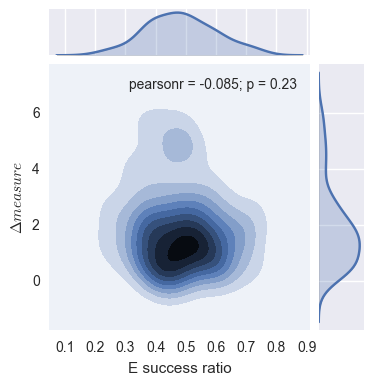

In [159]:
print 'Online-Offline correlation for DCG with RCM'
sns.jointplot(x='x',y='y', size=4, kind='kde', data=DCG_biased_RCM).set_axis_labels("E success ratio", "$\Delta measure$")

Online-Offline correlation for DCG with SDCM


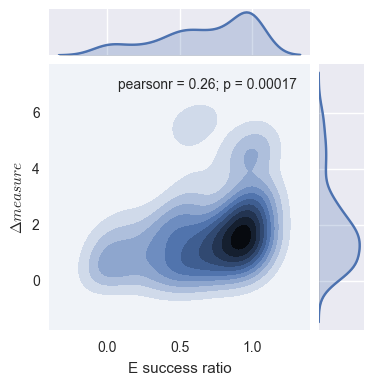

In [160]:
print 'Online-Offline correlation for DCG with SDCM'
sns.jointplot(x='x',y='y', size=4, kind='kde', data=DCG_biased_SDCM).set_axis_labels("E success ratio", "$\Delta measure$")

Online-Offline correlation for RBP with RCM


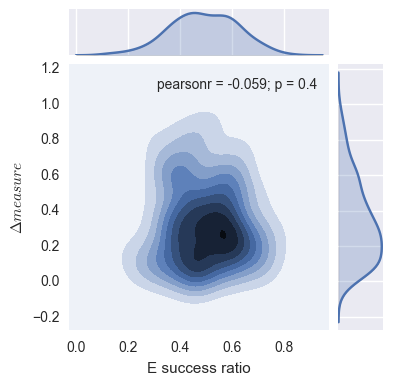

In [161]:
print 'Online-Offline correlation for RBP with RCM'
sns.jointplot(x='x',y='y', size=4, kind='kde', data=RBP_biased_RCM).set_axis_labels("E success ratio", "$\Delta measure$")

Online-Offline correlation for RBP with SDCM


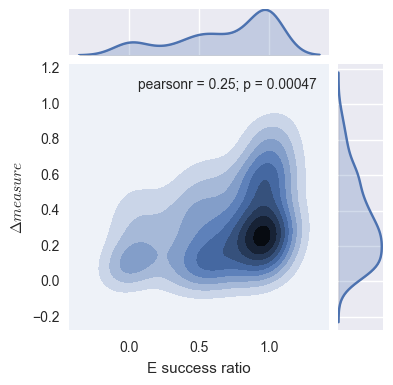

In [162]:
print 'Online-Offline correlation for RBP with SDCM'
sns.jointplot(x='x',y='y', size=4, kind='kde', data=RBP_biased_SDCM).set_axis_labels("E success ratio", "$\Delta measure$")

Online-Offline correlation for ERR with RCM


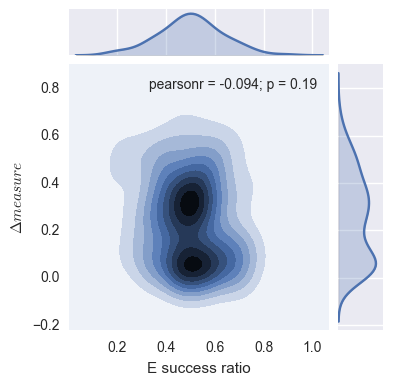

In [163]:
print 'Online-Offline correlation for ERR with RCM'
sns.jointplot(x='x',y='y', size=4, kind='kde', data=ERR_biased_RCM).set_axis_labels("E success ratio", "$\Delta measure$")

Online-Offline correlation for ERR with SDCM


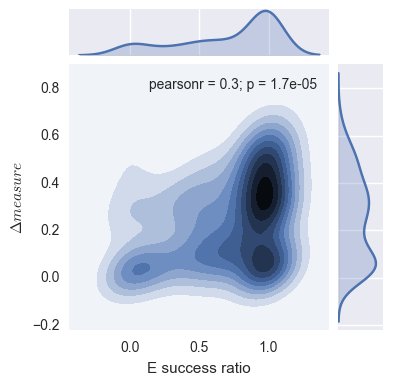

In [164]:
print 'Online-Offline correlation for ERR with SDCM'
sns.jointplot(x='x',y='y', size=4, kind='kde', data=ERR_biased_SDCM).set_axis_labels("E success ratio", "$\Delta measure$")

Online-Offline correlation for ERR with SDCM


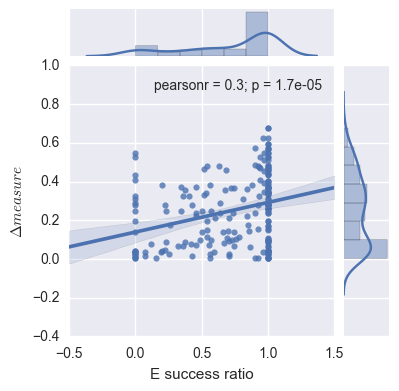

In [196]:
print 'Online-Offline correlation for ERR with SDCM'
sns.jointplot(x='x',y='y', size=4, kind='reg', data=ERR_biased_SDCM).set_axis_labels("E success ratio", "$\Delta measure$")

## Conclusions and analysis

- By studying the binomial test done previously, we can see that if we set a null hypothesis for the biased dataset to have a success greater than 0.5 using the Experimental algorithm, the hypotesis will be accepted. While if we use the general dataset that is not biased towards E, the null hypothesis is rejected.
- From the 1 sided test we can conclude that there is a tendency for the distribution mass of the dataset to favor the E algorithm when our offline measurements indicate this direction. However, as expected, when we sample from the entire dataset, there is no correlation between the offline and online measurements.
- Studying the plots and the interaction between the click models and the proportion - $\Delta measure$ relationship, we can see that the Random Click Model doesn't capture the small correlation between the 2 variables, that exists when the data is biased towards the E algorithm. This correlation, while small, is captured by the Simple Dependent Click Model, as observed both in the plots showing the distribution of the proportion and the ones mapping the bivariate distribution of the 2 variables.
- The SDCM makes much less assumption, and is much less biased then the Random Click Model, which can only map clicks on the documents without considering any form of relationships between previous clicks or documents. Therefore it is obvious that the SDCM model is prefered, as it can capture user behaviour better, as well as serve as a better baseline for online-offline comparisons.
- By observing the effect of the Probabilistic Interleaving algorithm, we can conclude that the additional smoothing provided add a 'sensability' to the process of interleaving the algorithms, and has the effect of reducing the effect of the biased data; if we compare the average proportion of E wins for the biased data using the TeamDraft and Probabilistic algorithms, the former tends more towards 1 and indicates a stronger correlation between offline and online performance of the E algorithm.
- Using the SDCM model the distribution of the proportion tends towards 1 for the biased dataset, with values generally hoverwing around ~0.7, which indicates a (slightly) better performance of the E algorithm in both settings.

### Pitfalls, drawbacks

- DCG and RBP do not take into account relevance of neighbour documents. ERR attempt to solve this by considering the relevance of previous document, but does not consider subsequent documents.
- SDCM doesn't allow users to skip documents when examining a SERP.
- Team Draft seems unreliable on small datasets, as it cannot break ties and create randomness if there are very few clicks.

#### "Appendix A" - Yandex Data preprocessing

In [1]:
def preprocess_yandex_data():
    # def preprocess_yandex_data():
    yandex_data = getYandexData()
    index = 0
    query_session_counter = 0
    all_queries = []
    while index < len(yandex_data):
        # Current row
        datapoint = yandex_data[index]

        # Current user session id
        session = datapoint[0]

        # Process current sessions queries and clicks.
        session_queries = []
        session_unique_queries = {}

        # Iterate through current session
        sess = session
        session_index = index
        while sess == session:
            row_datapoint = yandex_data[session_index]

            # Found a query
            if row_datapoint[2] == 'Q':
                query_id = row_datapoint[3]

                # We have never seen this query before
                if not query_id in session_unique_queries:
                    # Create query object
                    query = Query(session_id=query_session_counter, time_passed=row_datapoint[1], query_id=row_datapoint[3], region_id=row_datapoint[4], documents=[row_datapoint[i] for i in range(5, len(row_datapoint))])
                    query_session_counter += 1

                    # Store query as newest query
                    session_queries.append(query)
                    session_unique_queries[query_id] = query
                else:
                    # We have seen this query before, handle corner cases

                    # Same query id, determine difference if there is one.
                    prev_query = session_unique_queries[query_id]

                    # Queries are identical
                    if prev_query.identical_queries(row_datapoint):
                        # Simply move the position of the query to the top of the list.
                        session_queries.pop(session_queries.index(prev_query))
                        session_queries.append(prev_query)

                    elif prev_query.distinct_queries(row_datapoint):
                    # Same query, different documents, simply append them to the end of the list
                    # and move query to front.
                        prev_query.add_documents([row_datapoint[i] for i in range(5, len(row_datapoint))])
                        session_queries.pop(session_queries.index(prev_query))
                        session_queries.append(prev_query)
                    else:
                        # Same documents, only some documents are the same.
                        # Create a new query object from the current row.
                        # Create query object
                        query = Query(session_id=query_session_counter, time_passed=row_datapoint[1], query_id='###', region_id=row_datapoint[4], documents=[row_datapoint[i] for i in range(5, len(row_datapoint))])
                        query_session_counter += 1

                        # Only store query object as newest query.
                        session_queries.append(query)
            else:
                # Process click
                # Find latest query where click is present.
                document_clicked = row_datapoint[3]

                # Start from latest query
                for p_query in session_queries[::-1]:
                    r = p_query.has_click(document_clicked)
                    if r != -1:
                    # Found click
                        click = Click(session_id=p_query.session_id, time_passed=row_datapoint[1], document_id=document_clicked, query_id=p_query.query_id, rank=r)
                        # Store click
                        p_query.clicks.append(click)
                        break
                else:
                    print 'Document clicked is {0} in session {1}'.format(document_clicked, row_datapoint[0])
            session_index += 1
            if session_index < len(yandex_data):
                sess = yandex_data[session_index][0]
            else:
                sess = None

        all_queries.extend(session_queries)
        index = session_index
    
    return all_queries